# Application of SHAP explaining ResNet50 dataset

## <font color=blue>Explainer</font>

> classshap.Explainer(model, masker=None, link=CPUDispatcher(<function identity>), algorithm='auto', output_names=None, feature_names=None, linearize_link=True, seed=None, **kwargs)
Uses Shapley values to explain any machine learning model or python function.

> This is the primary explainer interface for the SHAP library. It takes any combination of a model and masker and returns a callable subclass object that implements the particular estimation algorithm that was chosen.

> __Build a new explainer for the passed model.__

> __Parameters:__
modelobject or function
    User supplied function or model object that takes a dataset of samples and computes the output of the model for those samples.

> __maskerfunction, numpy.array, pandas.DataFrame, tokenizer, None, or a list of these for each model input__

    The function used to “mask” out hidden features of the form masked_args = masker(*model_args, mask=mask). It takes input in the same form as the model, but for just a single sample with a binary mask, then returns an iterable of masked samples. These masked samples will then be evaluated using the model function and the outputs averaged. As a shortcut for the standard masking using by SHAP you can pass a background data matrix instead of a function and that matrix will be used for masking. Domain specific masking functions are available in shap such as shap.ImageMasker for images and shap.TokenMasker for text. In addition to determining how to replace hidden features, the masker can also constrain the rules of the cooperative game used to explain the model. For example shap.TabularMasker(data, hclustering=”correlation”) will enforce a hierarchial clustering of coalitions for the game (in this special case the attributions are known as the Owen values).

> __linkfunction__

    The link function used to map between the output units of the model and the SHAP value units. By default it is shap.links.identity, but shap.links.logit can be useful so that expectations are computed in probability units while explanations remain in the (more naturally additive) log-odds units. For more details on how link functions work see any overview of link functions for generalized linear models.

> __algorithm“auto”, “permutation”, “partition”, “tree”, or “linear”__

    The algorithm used to estimate the Shapley values. There are many different algorithms that can be used to estimate the Shapley values (and the related value for constrained games), each of these algorithms have various tradeoffs and are preferrable in different situations. By default the “auto” options attempts to make the best choice given the passed model and masker, but this choice can always be overriden by passing the name of a specific algorithm. The type of algorithm used will determine what type of subclass object is returned by this constructor, and you can also build those subclasses directly if you prefer or need more fine grained control over their options.

> __output_namesNone or list of strings__

    The names of the model outputs. For example if the model is an image classifier, then output_names would be the names of all the output classes. This parameter is optional. When output_names is None then the Explanation objects produced by this explainer will not have any output_names, which could effect downstream plots.

> __seed: None or int__

    seed for reproducibility

In [33]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap

## Loading Model and Data

In [42]:
# load pre-trained model and data
model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

In [43]:
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
#print("Number of ImageNet classes:", len(class_names))
#print("Class names:", class_names)

## SHAP ResNet50 model explanation for images

Build a partition explainer with: - the model (a python function) - the masker (a python function) - output names (a list of names of the output classes)

### A quick run with a few evaluations

In [51]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:5], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Partition explainer:  50%|████████████████                | 2/4 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Partition explainer: 100%|████████████████████████| 4/4 [00:27<00:00,  4.80s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

Partition explainer: 5it [00:37, 12.47s/it]                                     


#### Explainer options:
> 1. Above image masker uses a blurring technique called “inpaint_telea”. There are alternate masking options available to experiment with such as “inpaint_ns” and “blur(kernel_xsize, kernel_xsize)”.

> 2. Recommended number of evaluations is 300-500 to get explanations with sufficient granularity for the super pixels. More the number of evaluations, more the granularity but also increases run-time.

> Note: outputs=shap.Explanation.argsort.flip[:4] has been used in the code above for getting SHAP values because we want to get the top 4 most probable classes for each image i.e. top 4 classes with decreasing probability. Hence, a flip argsort sliced by 4 has been used.

## Visualizing SHAP values output

In this visualization:

- Red pixels represent positive SHAP values that contributed to classifying that image as that particular class.
- Blue pixels represent negative SHAP values that contributed to not classifying that image as that particular class.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


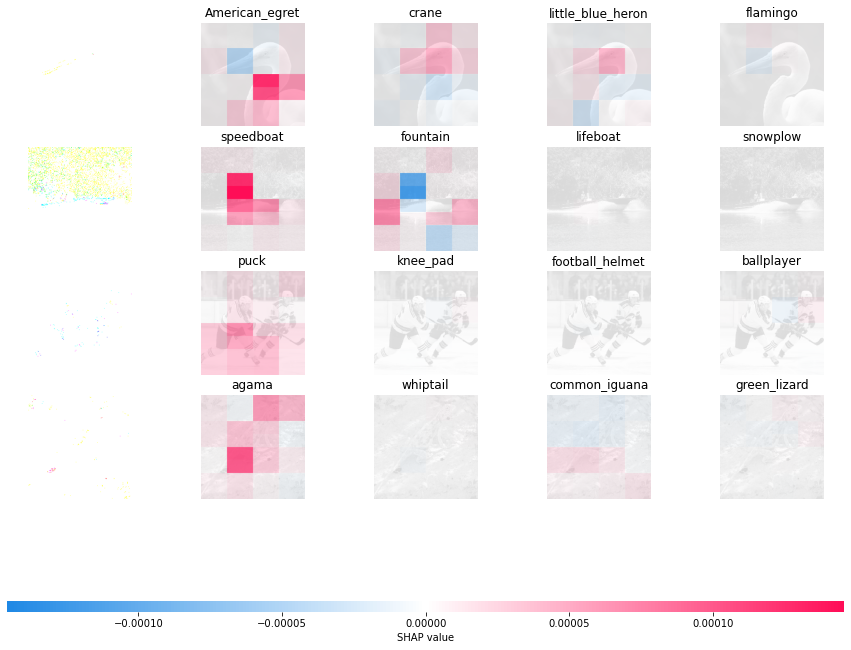

In [52]:
# output with shap values
shap.image_plot(shap_values)

> 1. In the first example, given bird image is classified as an American Egret with next probable classes being a Crane, Heron and Flamingo. It is the “bump” over the bird’s neck that causes it to be classified as an American Egret vs a Crane, Heron or a Flamingo. You can see the neck region of the bird appropriately highlighted in red super pixels.

> 2. In the second example, it is the shape of the boat with a man driving it, which causes it to be classified as a speedboat instead of a fountain, lifeboat or snowplow (appropriately highlighted in red super pixels).

> 3. In the third example, given puck hockey image is classified as a knee pad, football helmet, and a ballplayer. the area where it can be classified as puck hockey is around the "leg" of the hockey's player. They both wear the hockey shoes. You can see the region in red super pixels around both hockey player legs.

> 4. In the fourth example, we have a lizard image that is classified as an Agama. Comparing to other three images that are whiptail, common iguana, and green lizard. It is the colorful "body" and "head" section of the lizard that causes it to be classified as an agama. You can see around the area that I told is already highlighted in red super pixels, which means the SHAP value is high in that area.